In [1]:
#path = 'saved_model_1020_5class_combined_RMSprop_100_0.0001_ENCFRZ_False'
#path = 'saved_model_1020_RMSprop_100_0.0001_BNone_classweights_P3_S10_EncoderTrained'
#path = 'saved_model_1021_(960, 1152)_0.001'
#path = 'saved_model_1021_(960, 1152)_0.0005'
#path = 'saved_model_1026_(960, 1152)_0.001'
path = 'saved_model_1027_(960, 1152)_0.001_ENC_True'

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from IPython.display import clear_output
import matplotlib.pyplot as plt

#import segmentation_models as sm

import numpy as np
from numpy import genfromtxt
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

import glob
import cv2
import gc

from tqdm import tqdm
import time

2.2.0


In [3]:
"""
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

"\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [3]:
IMG_SIZE = (960, 1152)

In [4]:
def display(display_list, idx=None, only_inference=False, fig_size=15, title=['Ground Truth Mask', 'Pushed', 'Stamped']):
    """
    "only_inference" = True creates sample of inferenced image PNG file.
    """
    if only_inference:
        a = np.array(display_list)
        a = a.astype(np.float32) * 255.0
        
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list))
        #cv2.imwrite("EX{}.png".format(idx), cv2.cvtColor(a, cv2.COLOR_RGB2BGR))
    
    else:
        plt.figure(figsize=(fig_size,fig_size))
        #title = ['Ground Truth Mask', 'Pushed', 'Stamped', 'hole']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')

        plt.show()
    

In [5]:
def create_mask(pred_mask, num=0):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
    if test_mode:
        print("In testing Mode...")
        for i in range(num):
            pred_mask = model.predict(x, batch_size=1)
            display([x[i], y[i], create_mask(pred_mask, num=i)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [6]:
def draw_and_count(img, contours, label = '', draw_type = 'contour', show=True):
    # img : original image
    # contours: Contours found from opencv code
    assert label in ['push', 'stamp', 'hole'], "label must be either 'push' or 'stamp'"
    assert draw_type in ['bbox', 'contour'], "draw type must be either 'bbox' or 'contour'"
    
    if label=='push': val = 220
    if label=='stamp': val = 150
    if label=='hole': val = 250
        
        
    count = 0
    area = []
    width_height = []
    
    for idx, cnt in enumerate(contours):
        a = cv2.contourArea(cnt)
        if a < val:
            continue
        
        area.append(a)
        count += 1
        
        if draw_type == 'bbox':
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(125,125,0),2)
            width_height.append([w,h])
            print("{} #{} has width of {} and height of {}".format(label, idx, w, h))
            
        elif draw_type == 'contour':
            cv2.drawContours(img, [cnt], 0, (125, 125, 0), 2) 
            
    if show:        
        display([img], fig_size=8)
        print("{} {} found. Area: {}".format(count,label,area))

        
    return img, area, width_height, count

{0: [0.0, 0.0, 0.0], 1: [0.0, 1.0, 0.0], 2: [0.0, 1.0, 1.0], 3: [1.0, 0.23529412, 0.23529412], 4: [1.0, 1.0, 0.0]}


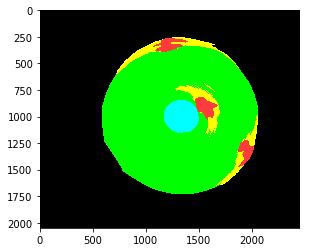

In [7]:
import cv2
from itertools import product
mask = imread('Mask_Image/[2021-10-13]11.25.55.086_1_2_Image.png') #2048 x 2448
cc = cv2.inRange(mask, (.99, 0, .99), (1,0,1))
mask[cc != 0] = [0,1,0]

colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

plt.imshow(mask)

color_dict = {i: list(x) for i,x in enumerate(colors)}

print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

# WITHOUT TRT

In [8]:
model = tf.keras.models.load_model(path)

In [318]:
"""
time_list = []
pred_mask = []

for idx,image in enumerate(tqdm(glob.glob("images/test/*.bmp"))):
    start = time.time()
    
    n = cv2.imread(image)
    n = tf.cast(n, tf.float32) / 255.0
    image = tf.image.resize(n, IMG_SIZE) 
    
    image = tf.expand_dims(image,0)
    pred_mask.append(model(image)) # N, H, W, 3
    
    ex = pred_mask[idx][0] # H,W,4
    
    pushed = np.round(tf.expand_dims(ex[:,:,1], -1)) + np.round(tf.expand_dims(ex[:,:,2], -1))
    circle = np.round(tf.expand_dims(ex[:,:,3], -1))
    stamped = np.round(tf.expand_dims(ex[:,:,2], -1))
    
    stamped_x = stamped.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed_stamp = cv2.dilate(stamped_x, k)
    contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    stamp_img, stamp_area, wh, stamp_count = draw_and_count(stamped_x, contours, label='stamp', show=False)
    
    pushed_x = pushed.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    push_img, push_area, wh, pushed_count = draw_and_count(pushed_x, contours, label='push', show=False)
    
    #print("Sample #{} has {} stamps and {} pushes. Stamp areas: {}, Push areas: {}".format(idx, stamp_count, pushed_count, 
    #                                                                                 stamp_area, push_area))
    
    time_list.append(time.time()-start)
    
print("Average inference time is: ", (np.mean(time_list) * 1000).round(3), "ms")
"""

100%|██████████| 46/46 [00:04<00:00, 10.30it/s]

Average inference time is:  96.475 ms


In [9]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

model = tf.saved_model.load(path, tags=[trt.tag_constants.SERVING])
graph_func = model.signatures[trt.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
frozen_func = trt.convert_to_constants.convert_variables_to_constants_v2(graph_func)

In [10]:
time_list = []
pred_mask = []

img_loc = glob.glob("Original_Image/*.png")
    
    
for idx,image in enumerate(tqdm(img_loc)):
    
    start = time.time()
    
    n = cv2.imread(image)
    n = tf.cast(n, tf.float32) / 255.0
    image = tf.image.resize(n, IMG_SIZE) #960,1152
    
    #image = tf.image.rgb_to_grayscale(image)
    image = tf.image.flip_left_right(image)
    
    image = tf.expand_dims(image,0)
    pred_mask.append(frozen_func(image)) # idx, 1, 1, H, W, 4
    
    ex = pred_mask[idx][0][0]
    
    pushed = np.round(tf.expand_dims(ex[:,:,1], -1)) + np.round(tf.expand_dims(ex[:,:,2], -1))
    circle = np.round(tf.expand_dims(ex[:,:,3], -1))
    stamped = np.round(tf.expand_dims(ex[:,:,2], -1))
    hole = np.round(tf.expand_dims(ex[:,:,4], -1))
    
    # STAMP
    stamped_x = stamped.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed_stamp = cv2.dilate(stamped_x, k)
    contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    stamp_img, stamp_area, wh, stamp_count = draw_and_count(stamped_x, contours, label='stamp', show=False)
    
    # PUSH
    pushed_x = pushed.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)
    
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    push_img, push_area, wh, pushed_count = draw_and_count(pushed_x, contours, label='push', show=False)


    #print("Sample #{} has {} stamps and {} pushes. Stamp areas: {}, Push areas: {}".format(idx, stamp_count, pushed_count, 
    #                                                                                  stamp_area, push_area))
    
    time_list.append(time.time()-start)
    
print("Average inference time is: ",(np.mean(time_list) * 1000).round(3), "ms")

100%|██████████| 80/80 [00:15<00:00,  5.28it/s]

Average inference time is:  188.157 ms


In [11]:
gc.collect()

train_x = []
train_y = []

for img in glob.glob("Original_Image/*.png"):
    
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE) #960,1152
    #n = tf.image.rgb_to_grayscale(n)

    n = tf.image.flip_left_right(n)

    train_x.append(n)
    
    dir = "Mask_Image/" # "/".join(img.split("/")[:-1]) + "/Mask_Image/"
    file_name = img.split("/")[-1] # img.split("/")[-1].split('.')[0]

    #MASK
    y = imread(dir+file_name) # imread(dir+file_name+".png")
    
    cc = cv2.inRange(y, (.99, 0, .99), (1,0,1))
    y[cc != 0] = [0,1,0]
    
    #dir = "/".join(img.split("/")[:-1]) + "/new_gt_mask/"
    #file_name = img.split("/")[-1].split('.')[0]

    #y = cv2.imread(dir+file_name+".png")

    a = rgb_to_onehot(y, color_dict) #change to one hot
    
    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot #0,1,2,3
    bbb = tf.image.resize(bb, IMG_SIZE) #960,1152
    
    bbb = tf.image.flip_left_right(bbb)

    train_y.append(bbb)

test_x = tf.convert_to_tensor(train_x)
test_y = tf.convert_to_tensor(train_y)

print(test_x.shape)
print(test_y.shape)

(80, 960, 1152, 3)
(80, 960, 1152, 1)


Ground truth numbers:
1.   black_ng:
1, 2/1, 3, 4, 4/2, 4/2, 3/1, 1, 1, 4/1
3/3, 2, 4/1, 3/1
2.   silver_ng:
4, 4/1, 4/2, 3/1, 1, 1/1, 4/1,
3/2, 2, 4, 2/1




In [13]:
"""
np.savez_compressed('test_img_array', test_0 = np.float32(pred_mask[0][0][0]), test_1 = np.float32(pred_mask[1][0][0]), 
                   test_2 = np.float32(pred_mask[2][0][0]), test_3 = np.float32(pred_mask[3][0][0]))
"""

"\nnp.savez_compressed('test_img_array', test_0 = np.float32(pred_mask[0][0][0]), test_1 = np.float32(pred_mask[1][0][0]), \n                   test_2 = np.float32(pred_mask[2][0][0]), test_3 = np.float32(pred_mask[3][0][0]))\n"

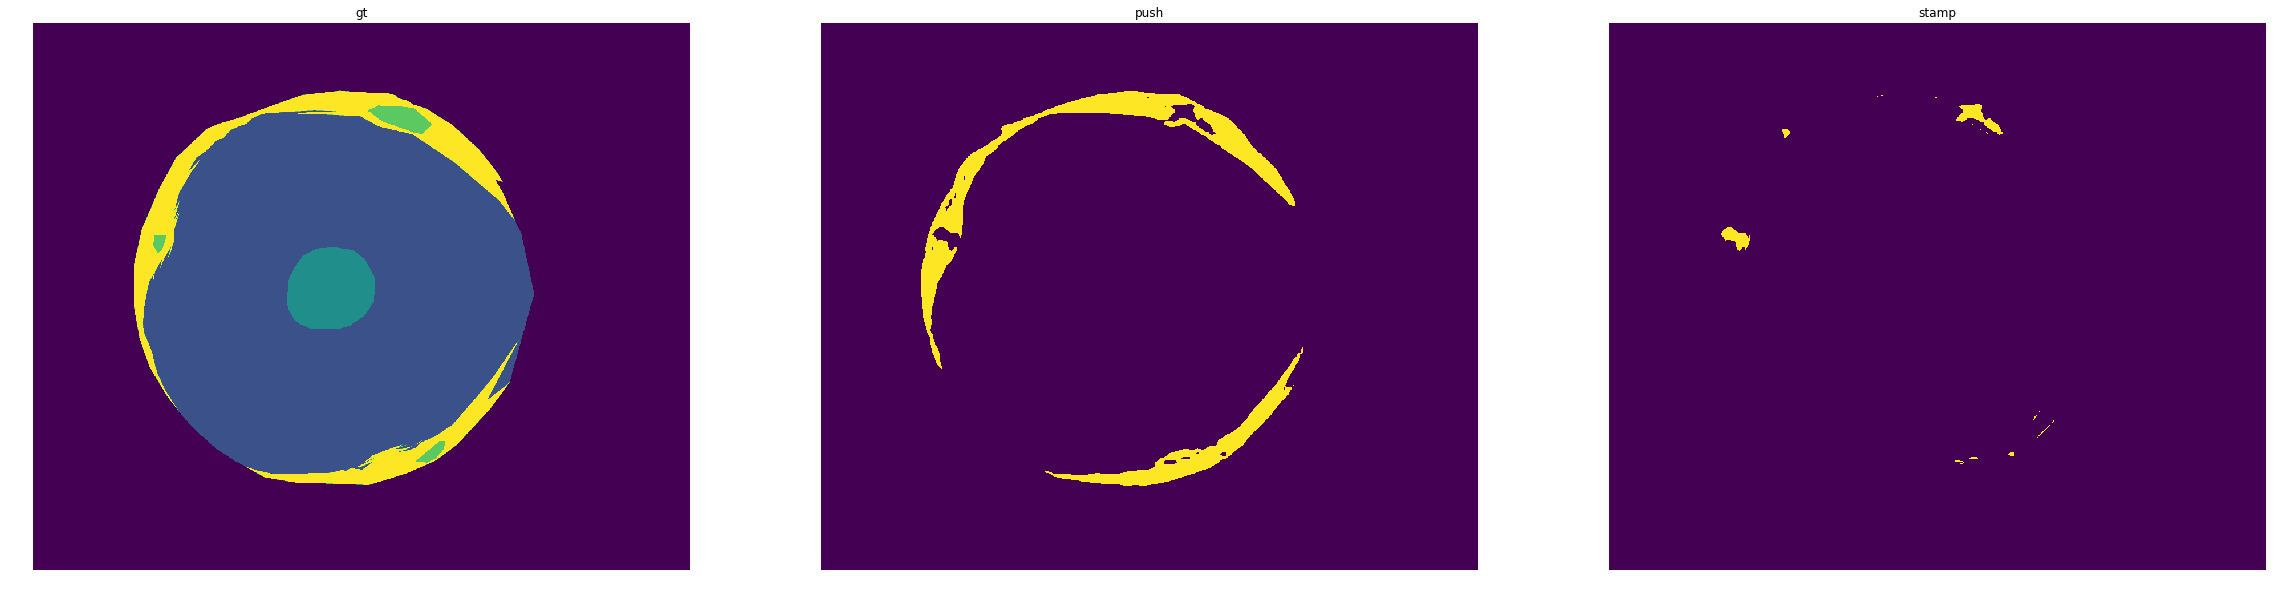

In [19]:
idx = 11

pred = np.float32(pred_mask[idx][0][0])

ex = np.round(pred) # ex = H,W,5
# 0 bg, 1 Circle 2 hole 3 stamp 4 psuhed 

circle = tf.expand_dims(ex[:,:,1], -1)
pushed = tf.expand_dims(ex[:,:,4], -1) 
bg = tf.expand_dims(ex[:,:,0], -1)
hole = tf.expand_dims(ex[:,:,2], -1)
stamped = tf.expand_dims(ex[:,:,3], -1)

#bg = 0, pushed = 1, stamped = 2, circle = 3

gt_mask = np.round(test_y[idx],decimals = 0)
#print((gt_mask==1).sum())

display([gt_mask, pushed, stamped], fig_size=40, title=['gt','push','stamp'])

In [20]:
""" NEEDED for 6 class?
mask = imread('Mask_Image/[2021-10-13]11.25.55.086_1_2_Image.png') #2048 x 2448
colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)
orig_color_dict = {i: list(x) for i,x in enumerate(colors)}
"""

" NEEDED for 6 class?\nmask = imread('Mask_Image/[2021-10-13]11.25.55.086_1_2_Image.png') #2048 x 2448\ncolors = np.unique(tf.reshape(mask,[-1,3]), axis=0)\norig_color_dict = {i: list(x) for i,x in enumerate(colors)}\n"

In [21]:
def onehot_to_rgb(one_hot):

    channel_0 = np.zeros(IMG_SIZE + (1,)) #prediction
    channel_1 = np.zeros(IMG_SIZE + (1,))
    channel_2 = np.zeros(IMG_SIZE + (1,))
    
    ex = one_hot # ex = H,W,1

    #pushed = tf.expand_dims(ex[:,:,1], -1) + tf.expand_dims(ex[:,:,2], -1)
    #circle = tf.expand_dims(ex[:,:,3], -1)
    #stamped = tf.expand_dims(ex[:,:,2], -1) # stamped = H,W,1
    #bg = tf.expand_dims(ex[:,:,0], -1)
    #hole = tf.expand_dims(ex[:,:,4], -1)

    channel_0[ex==1] = color_dict[1][0]
    channel_1[ex==1] = color_dict[1][1]
    channel_2[ex==1] = color_dict[1][2]

    channel_0[ex==3] = color_dict[3][0]
    channel_1[ex==3] = color_dict[3][1]
    channel_2[ex==3] = color_dict[3][2]

    channel_0[ex==2] = color_dict[2][0]
    channel_1[ex==2] = color_dict[2][1]
    channel_2[ex==2] = color_dict[2][2]

    channel_0[ex==0] = color_dict[0][0]
    channel_1[ex==0] = color_dict[0][1]
    channel_2[ex==0] = color_dict[0][2]
    
    channel_0[ex==4] = color_dict[4][0]
    channel_1[ex==4] = color_dict[4][1]
    channel_2[ex==4] = color_dict[4][2]
    

    com = tf.concat([channel_0, channel_1, channel_2], -1)
    
    return com

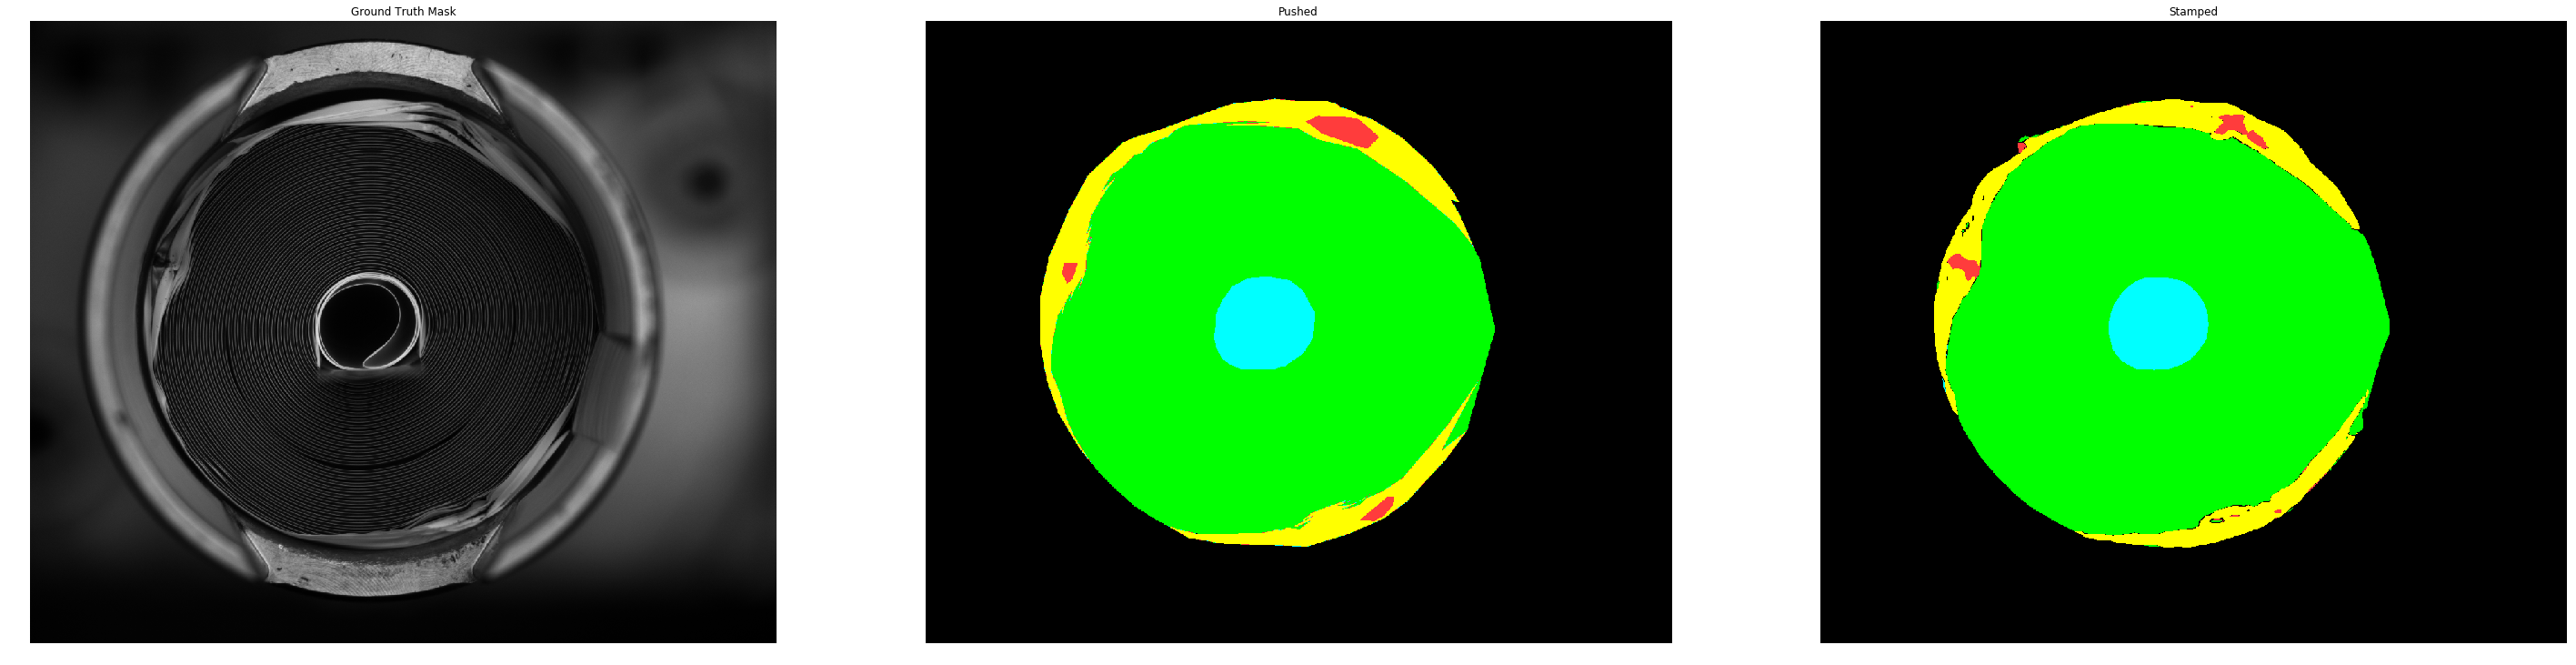

In [22]:
channel_0 = np.zeros(IMG_SIZE+(1,)) #prediction
channel_1 = np.zeros(IMG_SIZE+(1,))
channel_2 = np.zeros(IMG_SIZE+(1,))

# 0 bg, 1 Circle 2 hole 3 stamp 4 psuhed 

channel_0[pushed==1] = color_dict[4][0]
channel_1[pushed==1] = color_dict[4][1]
channel_2[pushed==1] = color_dict[4][2]

channel_0[circle==1] = color_dict[1][0]
channel_1[circle==1] = color_dict[1][1]
channel_2[circle==1] = color_dict[1][2]

channel_0[stamped==1] = color_dict[3][0]
channel_1[stamped==1] = color_dict[3][1]
channel_2[stamped==1] = color_dict[3][2]

channel_0[bg==1] = color_dict[0][0]
channel_1[bg==1] = color_dict[0][1]
channel_2[bg==1] = color_dict[0][2]

channel_0[hole==1] = color_dict[2][0]
channel_1[hole==1] = color_dict[2][1]
channel_2[hole==1] = color_dict[2][2]

com = tf.concat([channel_0, channel_1, channel_2], -1)

display([test_x[idx],onehot_to_rgb(gt_mask), com],fig_size=50)
#display(com, idx=idx, only_inference=True)

In [18]:
"""
idx = 19
gt_mask = np.round(test_y[idx],decimals = 0)
display([tf.image.flip_left_right(tf.image.grayscale_to_rgb(test_x[idx])),tf.image.flip_left_right(onehot_to_rgb(gt_mask))])
"""

'\nidx = 19\ngt_mask = np.round(test_y[idx],decimals = 0)\ndisplay([tf.image.flip_left_right(tf.image.grayscale_to_rgb(test_x[idx])),tf.image.flip_left_right(onehot_to_rgb(gt_mask))])\n'

In [57]:
img1 = np.array(test_x[idx],np.float64)
img2 = np.array(com, np.float64)
print(img1.shape, img2.shape)

(960, 1152, 3) (960, 1152, 3)


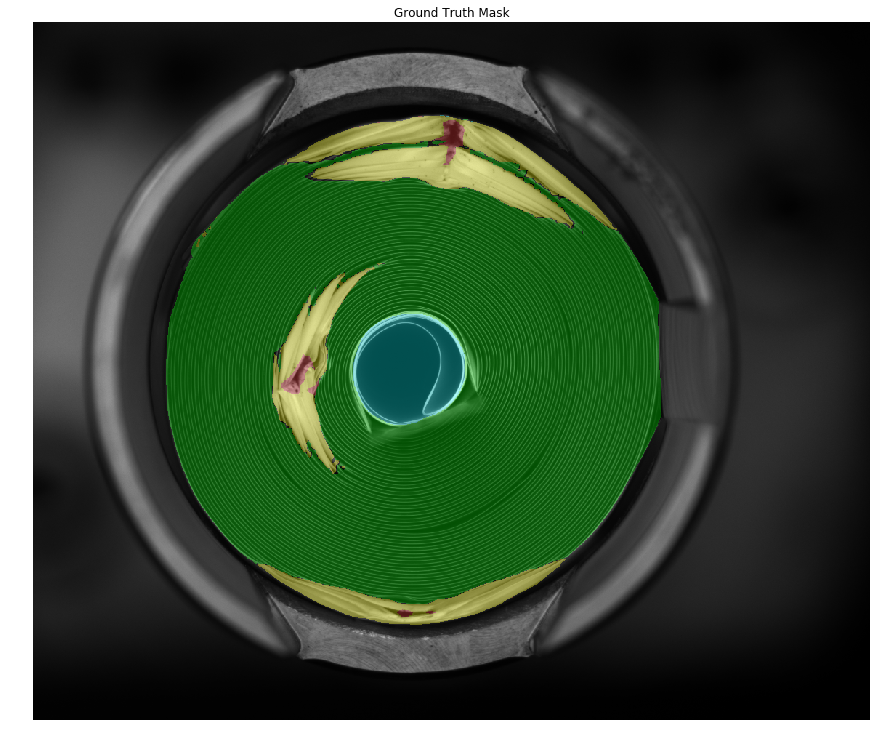

In [58]:
alpha = 0.7

#blended = img1 * 0.5  + img2*0.5
#print(blended.shape)
blended = cv2.addWeighted(img1, alpha, img2, (1-alpha), 0) # 방식2
#blended1 = blended.astype(np.uint8)

display([blended])

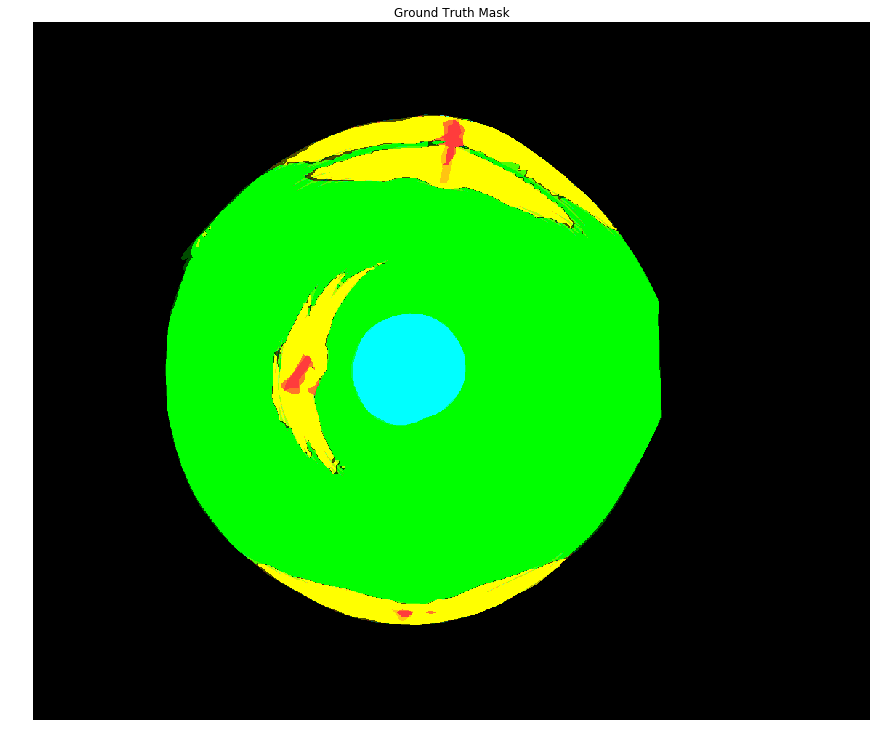

In [56]:
img1 = np.array(onehot_to_rgb(gt_mask))
img2 = np.array(com)

alpha = 0.3

#blended = img1 * 0.5  + img2*0.5
#print(blended.shape)
blended = cv2.addWeighted(img1, alpha, img2, (1-alpha), 0) # 방식2
#blended1 = blended.astype(np.uint8)

display([blended])


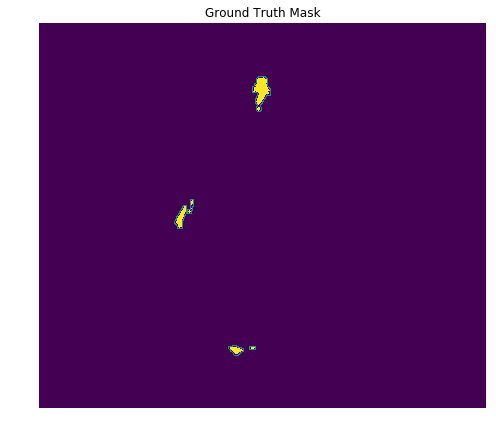

5 stamp found. Area: [197.5, 912.0, 1453.5, 469.5, 3454.0]


In [22]:
stamped_x = np.array(stamped).astype(np.uint8) * 255
k = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed_stamp = cv2.dilate(stamped_x, k)

contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
img, area, wh, count = draw_and_count(stamped_x, contours, label="stamp")

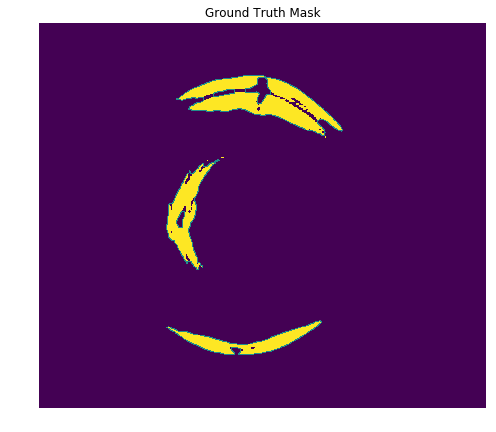

6 push found. Area: [14794.0, 749.0, 19022.5, 852.0, 2848.0, 44040.5]


In [23]:
pushed_x = np.array(pushed).astype(np.uint8) * 255
k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)

contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
img, area, wh, count = draw_and_count(pushed_x, contours, label='push', draw_type='contour')

In [28]:
"""
channel_0 = np.zeros((480,576,1)) #prediction
channel_1 = np.zeros((480,576,1))
channel_2 = np.zeros((480,576,1))

channel_0[pushed==1] = color_dict[1][0]
channel_1[pushed==1] = color_dict[1][1]
channel_2[pushed==1] = color_dict[1][2]

channel_0[circle==1] = color_dict[3][0]
channel_1[circle==1] = color_dict[3][1]
channel_2[circle==1] = color_dict[3][2]

channel_0[stamped==1] = color_dict[2][0]
channel_1[stamped==1] = color_dict[2][1]
channel_2[stamped==1] = color_dict[2][2]

channel_0[bg==1] = color_dict[0][0]
channel_1[bg==1] = color_dict[0][1]
channel_2[bg==1] = color_dict[0][2]

com = tf.concat([channel_0, channel_1, channel_2], -1)


display(com, idx, only_inference=True)
"""

'\nchannel_0 = np.zeros((480,576,1)) #prediction\nchannel_1 = np.zeros((480,576,1))\nchannel_2 = np.zeros((480,576,1))\n\nchannel_0[pushed==1] = color_dict[1][0]\nchannel_1[pushed==1] = color_dict[1][1]\nchannel_2[pushed==1] = color_dict[1][2]\n\nchannel_0[circle==1] = color_dict[3][0]\nchannel_1[circle==1] = color_dict[3][1]\nchannel_2[circle==1] = color_dict[3][2]\n\nchannel_0[stamped==1] = color_dict[2][0]\nchannel_1[stamped==1] = color_dict[2][1]\nchannel_2[stamped==1] = color_dict[2][2]\n\nchannel_0[bg==1] = color_dict[0][0]\nchannel_1[bg==1] = color_dict[0][1]\nchannel_2[bg==1] = color_dict[0][2]\n\ncom = tf.concat([channel_0, channel_1, channel_2], -1)\n\n\ndisplay(com, idx, only_inference=True)\n'

In [17]:
def get_iou(test_y, cls): #0:bg 1:circle 2:hole 3:small 4:stamped 5:pushed
    iou = []
    fp = []
    fn = []
    tn = []
    tp = []
    
    for idx in range(80):
        ex = np.round(pred_mask[idx][0][0]) # ex = H,W,4

        y_pred = tf.expand_dims(ex[:,:,cls], -1)

        gt_mask = np.round(test_y[idx],decimals = 0)
        if cls not in np.unique(gt_mask): continue
            
        y_true = np.zeros(IMG_SIZE + (1,))
        y_true[gt_mask == cls] = 1

        FP = len(np.where(y_pred - y_true  == -1)[0])
        FN = len(np.where(y_pred - y_true  == 1)[0])
        TP = len(np.where(y_pred + y_true ==2)[0])
        TN = len(np.where(y_pred + y_true == 0)[0])
        
        cmat = [[TP, FN], [FP, TN]]
        
        if TP+FN+FP == 0 or FN+TP ==0 or FP+TN==0: 
            continue
        
        fp.append(FP)
        fn.append(FN)
        tn.append(TN)
        tp.append(TP)
    
        iou.append (TP/(TP+FN+FP))
        
    
    return ( np.mean(iou), np.mean(fn), np.mean(fp), np.mean(tn), np.mean(tp) )
        
stamp_iou, stamp_fn, stamp_fp, stamp_tn, stamp_tp = get_iou(test_y, cls=3)
pushed_iou, pushed_fn, pushed_fp, pushed_tn, pushed_tp = get_iou(test_y, cls=4)
circle_iou, circle_fn, circle_fp, circle_tn, circle_tp = get_iou(test_y, cls=1)
hole_iou, hole_fn, hole_fp, hole_tn, hole_tp = get_iou(test_y, cls=2)

In [18]:
print("STAMP IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(stamp_iou, stamp_fn, stamp_fp, stamp_tn, stamp_tp, 
                                                                               stamp_fn/(stamp_fn+stamp_tp), 
                                                                               stamp_fp/(stamp_fp+stamp_tn)))
print("PUSHED IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(pushed_iou, pushed_fn, pushed_fp,pushed_tn,pushed_tp, 
                                                                                pushed_fn/(pushed_fn+pushed_tp), 
                                                                               pushed_fp/(pushed_fp+pushed_tn)))
print("CIRCLE IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(circle_iou, circle_fn, circle_fp, circle_tn,
                                                                               circle_tp, circle_fn/(circle_fn+circle_tp), 
                                                                               circle_fp/(circle_fp+circle_tn)))
print("HOLE IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(hole_iou, hole_fn, hole_fp, hole_tn,
                                                                               hole_tp, hole_fn/(hole_fn+hole_tp), 
                                                                               hole_fp/(hole_fp+hole_tn)))


STAMP IoU: 0.23086356564334376, FN: 828.7413793103449, FP: 2332.0689655172414, TN: 1101070.7068965517, TP: 1688.4827586206898, FNR: 0.32922828238549584, FPR: 0.0021135246498679844
PUSHED IoU: 0.6950927657585658, FN: 3927.5833333333335, FP: 5404.316666666667, TN: 1066825.2666666666, TP: 29762.833333333332, FNR: 0.1165786511990304, FPR: 0.005040260733961283
CIRCLE IoU: 0.9769974433113882, FN: 3736.3125, FP: 2734.45, TN: 780041.075, TP: 319408.1625, FNR: 0.011562359220283746, FPR: 0.003493274780148498
HOLE IoU: 0.9169758251357656, FN: 858.2, FP: 1019.4, TN: 1086541.5125, TP: 17500.8875, FNR: 0.04674524264890616, FPR: 0.0009373268092696372
